In [1]:
import pandas as pd
from tensorflow.python.client import device_lib

from src.data_processing.dataset import DataSet
from src.models import TCN_Seq2Seq
from tensorflow.keras.callbacks import EarlyStopping
import datetime

/home/michael/university_courses/lab_course/lab_group_michael_maciej/venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [2]:
#set config_path to any path on your system
# config_path = "/home/michael/university_courses/lab_course/lab_group_michael_maciej/model_configs/model_config_TCN_TCN"

In [3]:

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 471921423291673618,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7231176704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9813045087067974244
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:08:00.0, compute capability: 6.1"]

In [4]:
data_path = "/home/michael/university_courses/lab_course/lab_group_michael_maciej" \
            "/data_vertraulich/building_1/all_months.xlsx"

In [5]:
dataset = DataSet()

In [6]:
dataset.load_data(data_path, file_type="xlsx")


In [7]:
features_input_encoder = [
    "Weather - Outdoor temperature (Logging)",
    "Internal load - Load profile persons (Load profile)",
    "Heizkreis_Heizkoerper - Vorlauftemperatur (Logging)",
]

features_input_decoder = [
    "Weather - Outdoor temperature (Forecast)",
]

feature_target = "Heizkreis_Heizkoerper - Vorlauftemperatur (Forecast)"


In [22]:
split_ratio = 0.80579
input_seq_len = 700
output_seq_len = 192
smoothing_operations = None
temporal_encoding_modes = ["seasons", "weekdays", "hours", "holidays"]
autoregressive = False


In [23]:

split_date = datetime.date(2019, 1, 1)
dataset.process(features_input_encoder,
                features_input_decoder,
                feature_target,
                input_seq_len,
                output_seq_len,
                split_ratio = None,
                split_date = split_date,
                smoothing_operations=smoothing_operations,
                temporal_encoding_modes=temporal_encoding_modes,
                autoregressiive=autoregressive)

seasons
weekdays
hours
holidays


In [24]:
# dataset.save_dataset_config(config_path)

In [25]:
# X_train, y_train, X_val, y_val = dataset.train_test_split(split_ratio)
considered_months = [1,2,3,4,5,6,7]
X_train, y_train, X_val, y_val = dataset.train_test_split_date(split_date, considered_months=considered_months)

In [31]:
from tensorflow.keras.optimizers import Adam

model = TCN_Seq2Seq(
        )

model.build(
    num_layers_tcn = None,
    num_filters = 6,
    kernel_size = 9,
    dilation_base = 2,
    dropout_rate = 0.2,
    key_size = 6,
    value_size = 6,
    num_attention_heads = 2,
    neurons_output = [16],
    activation = "relu",
    kernel_initializer = "he_normal",
    batch_norm_tcn = True,
    layer_norm_tcn = False,)
model.compile(optimizer=Adam(lr=0.003, decay=1e-3))


In [32]:

cb_early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train,
          y_train,
          (X_val, y_val),
          epochs=50,
          batch_size=64,
          
          callbacks = cb_early_stopping
          )


Epoch 1/50
629/629 [==============================] - 45s 58ms/step - loss: 0.3522 - val_loss: 0.2456
Epoch 2/50
629/629 [==============================] - 34s 55ms/step - loss: 0.2179 - val_loss: 0.2458
Epoch 3/50
629/629 [==============================] - 34s 55ms/step - loss: 0.1821 - val_loss: 0.2483
Epoch 4/50
629/629 [==============================] - 34s 55ms/step - loss: 0.1647 - val_loss: 0.2412
Epoch 5/50
629/629 [==============================] - 34s 54ms/step - loss: 0.1537 - val_loss: 0.2401
Epoch 6/50
629/629 [==============================] - 34s 54ms/step - loss: 0.1456 - val_loss: 0.2432
Epoch 7/50
529/629 [========================>.....] - ETA: 4s - loss: 0.1399

KeyboardInterrupt: 

In [ ]:
model.parameter_search(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size = 64,
        results_path = "param_search_new/search_13",
        patience=5,
        loss = "mse",
        l2_reg = [0],
        max_trials = 100,
        executions_per_trial = 1,
        num_filters = [4, 6, 8],
        neurons_output = [16],
        kernel_size = [11, 15, 19, 23],
        dilation_base = [2],
        dropout_rate = [0.1, 0.2, 0.3],
        key_value_size = [4, 6, 8],
        num_attention_heads = [1, 2],
        activation = ["elu"],
        kernel_initializer = ["he_normal"],
        weight_norm_tcn = [False],
        batch_norm_tcn = [False],
        layer_norm_tcn = [True],
    )

In [14]:
# evaluate train and val set with scaling
score_train = model.eval(X_train, y_train, dataset.scaler_y, iterations=1)
print(f"score train: {score_train}")
score_val = model.eval(X_val, y_val, dataset.scaler_y, iterations=1)
print(f"score val: {score_val}")

score train: 46.40223879903946
score val: 55.88976449922794


In [ ]:
score_val = model.eval(X_val, y_val, iterations=1)
print(f"score val: {score_val}")

In [ ]:
# evaluate train and val set without scaling
#score_train = model.eval(X_train, y_train, iterations=10)
#print(f"score train: {score_train}")
#score_val = model.eval(X_val, y_val, iterations=10)
#print(f"score val: {score_val}")

In [53]:
# Make predictions for whole dataset
preds = model.predict(dataset.X, scaler = dataset.scaler_y, iterations=1)
preds_flat = preds.reshape(preds.shape[0], -1)

In [54]:
# Create dataset with predictions
df_with_preds = dataset.create_dataframe_with_predictions(preds_flat)



In [22]:
preds.shape

(95973, 192, 1)

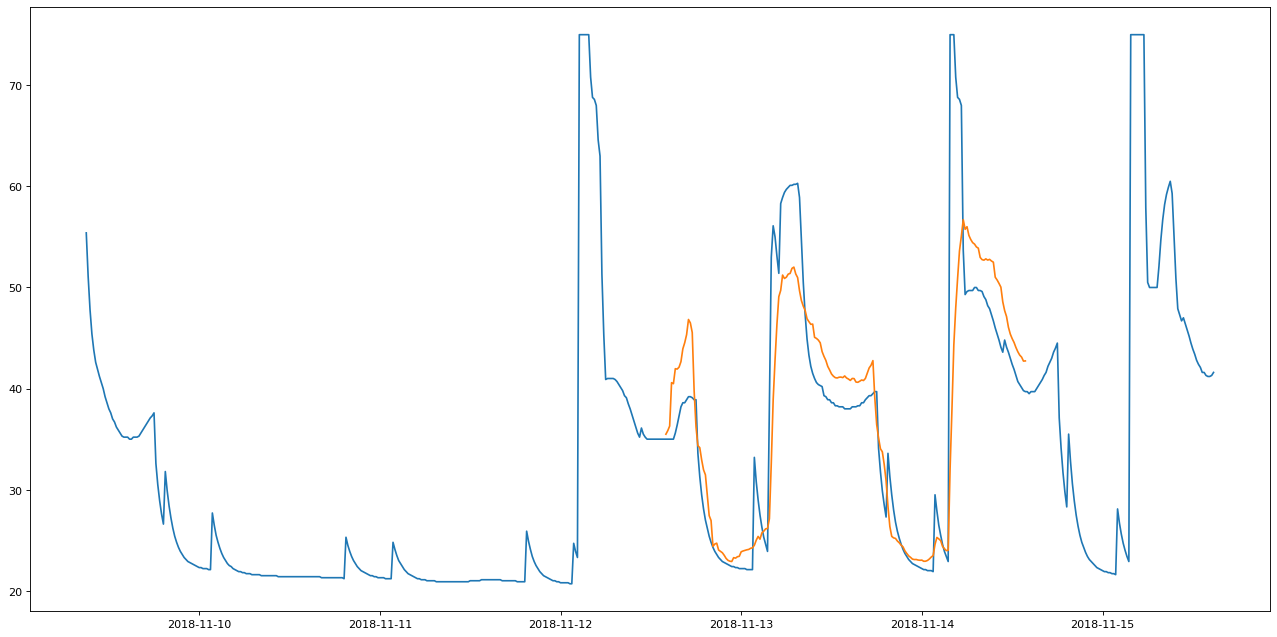

In [55]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
df_chunk = df_with_preds[73000:73600]
preds_last = df_chunk[["date / time", "predictions"]][-292:-291]
figure(figsize=(20, 10), dpi=80)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-292:-100],preds_last["predictions"].values[0] )

ValueError: x and y must have same first dimension, but have shapes (672,) and (192,)

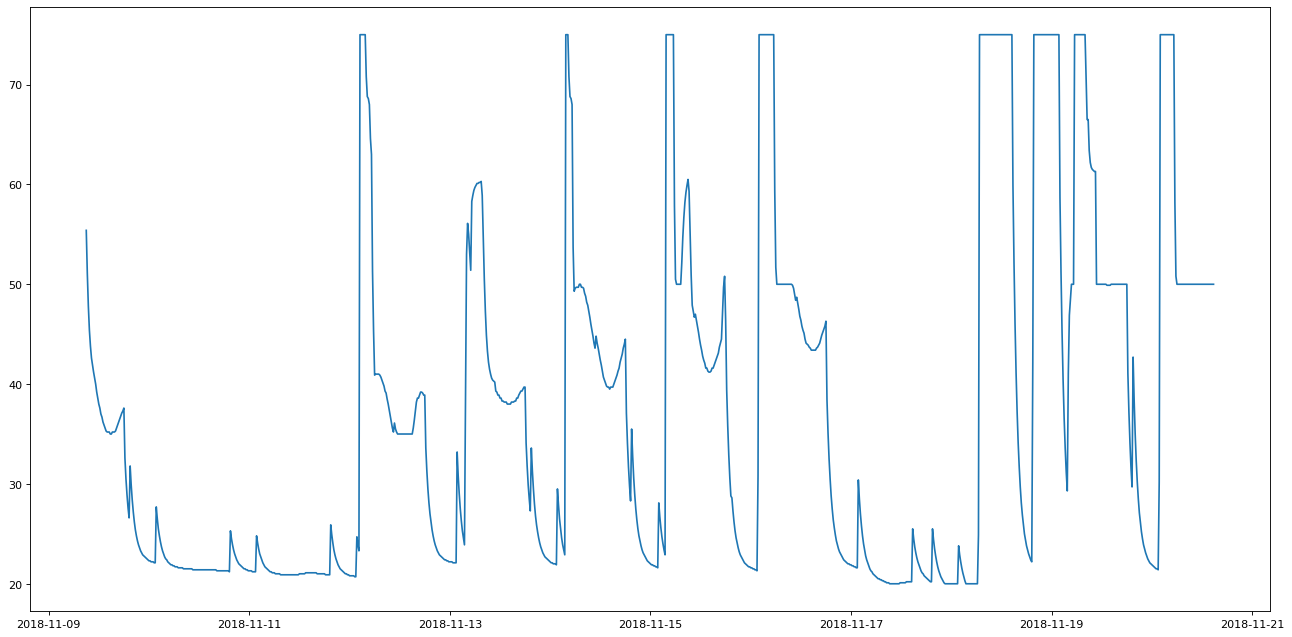

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
df_chunk = df_with_preds[73000:74080]
preds_last = df_chunk[["date / time", "predictions"]][-772:-771]
figure(figsize=(20, 10), dpi=80)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-772:-100],preds_last["predictions"].values[0] )

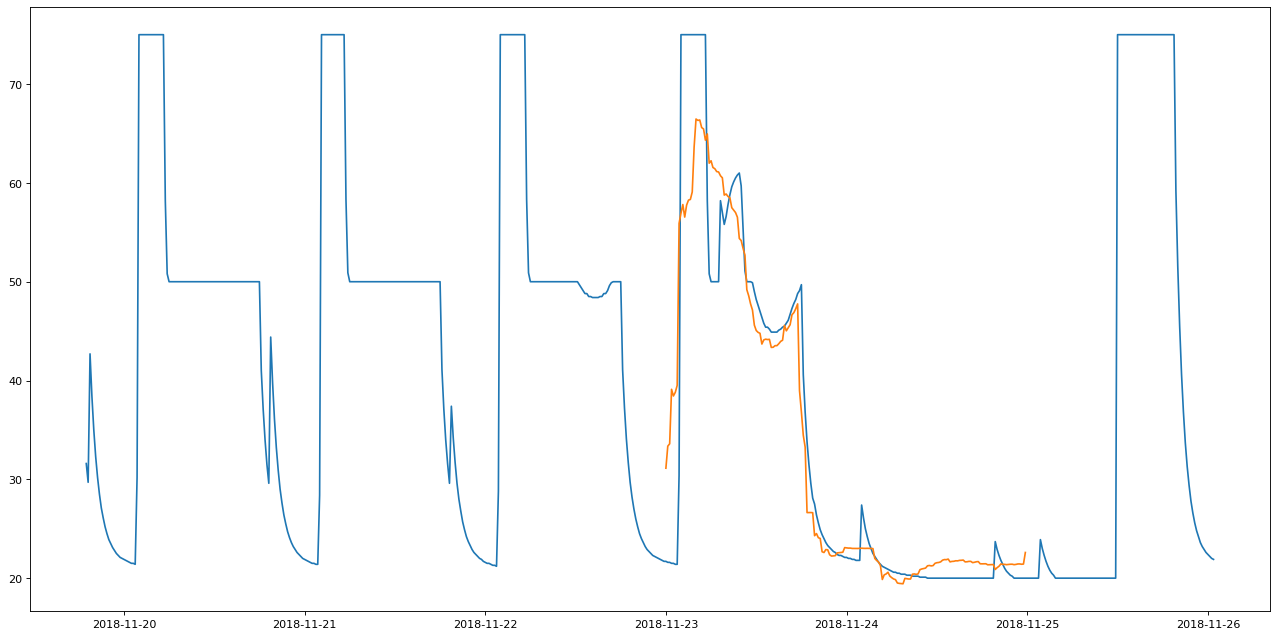

In [22]:
df_chunk = df_with_preds[74000:74600]
preds_last = df_chunk[["date / time", "predictions"]][-292:-291]
figure(figsize=(20, 10), dpi=80)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-292:-100],preds_last["predictions"].values[0] )

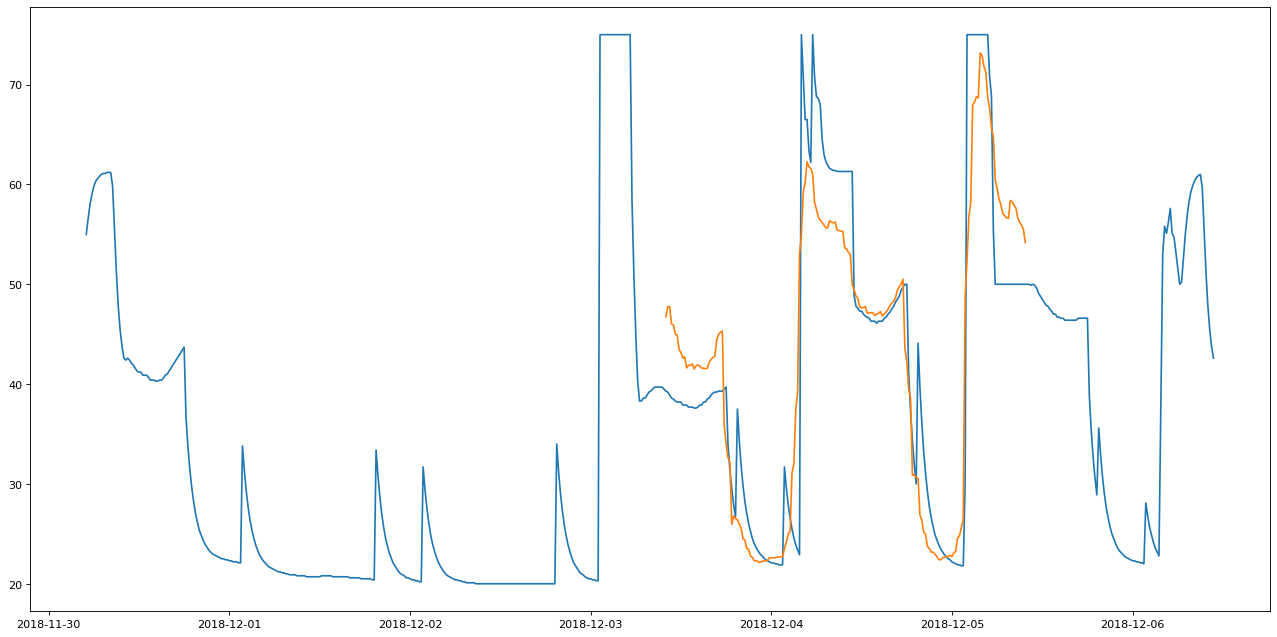

In [23]:
df_chunk = df_with_preds[75000:75600]
preds_last = df_chunk[["date / time", "predictions"]][-292:-291]
figure(figsize=(20, 10), dpi=80)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-292:-100],preds_last["predictions"].values[0] )

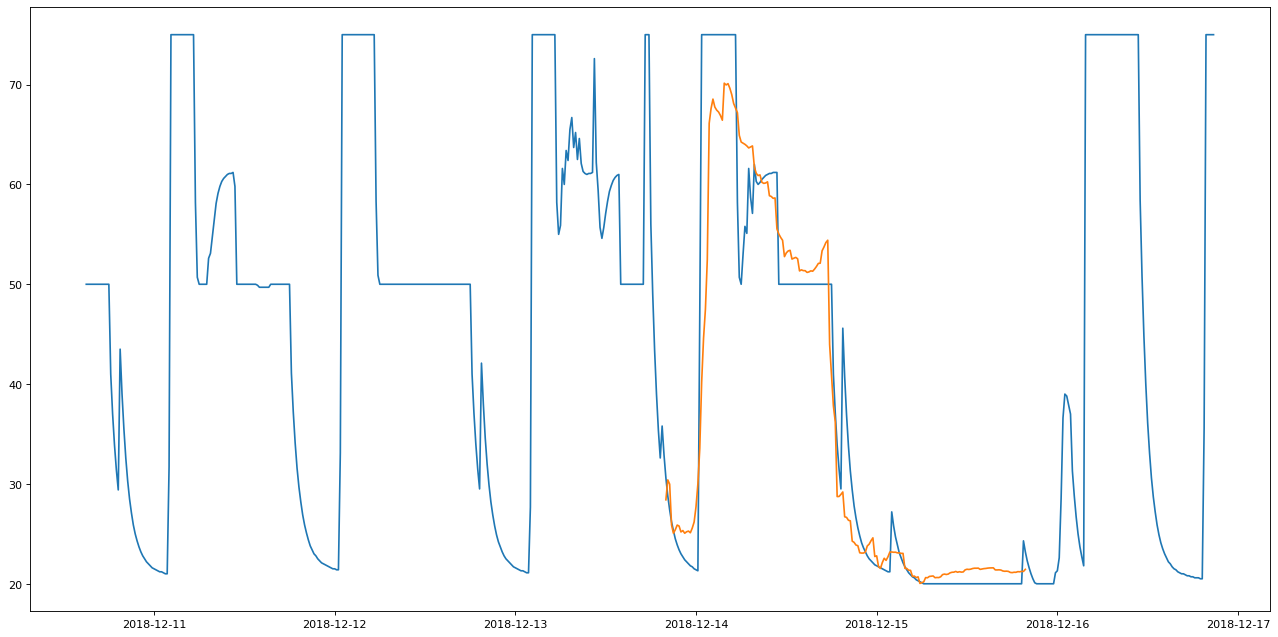

In [24]:
df_chunk = df_with_preds[76000:76600]
preds_last = df_chunk[["date / time", "predictions"]][-292:-291]
figure(figsize=(20, 10), dpi=80)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-292:-100],preds_last["predictions"].values[0] )

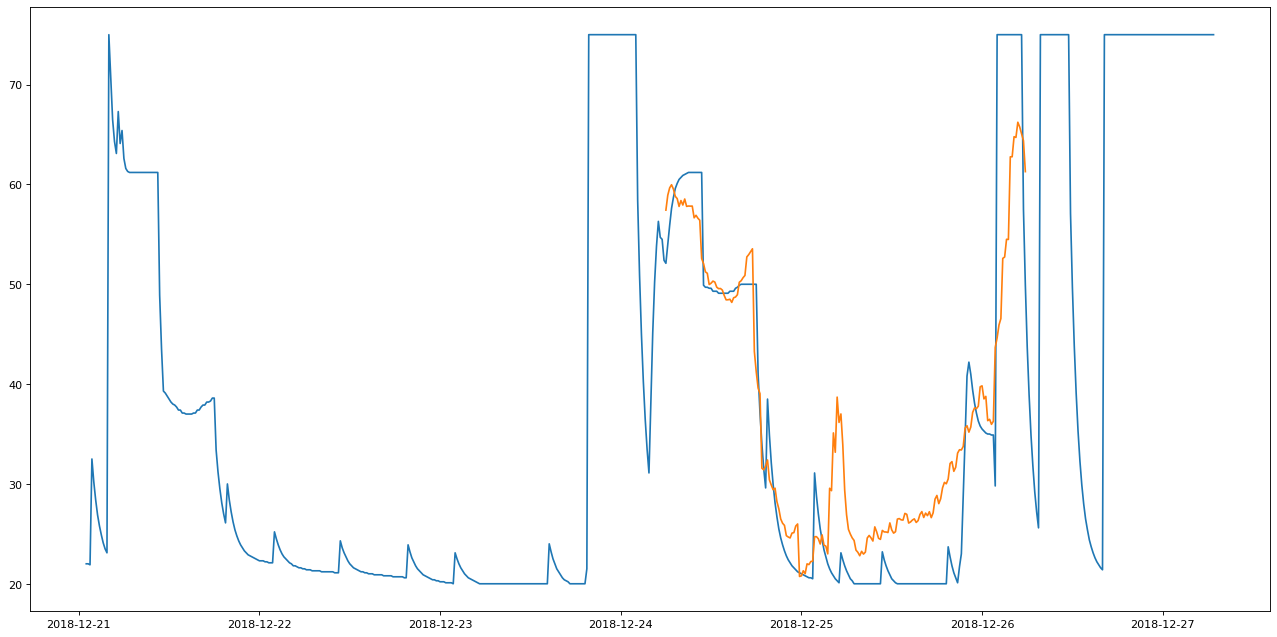

In [25]:
df_chunk = df_with_preds[77000:77600]
preds_last = df_chunk[["date / time", "predictions"]][-292:-291]
figure(figsize=(20, 10), dpi=80)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-292:-100],preds_last["predictions"].values[0] )

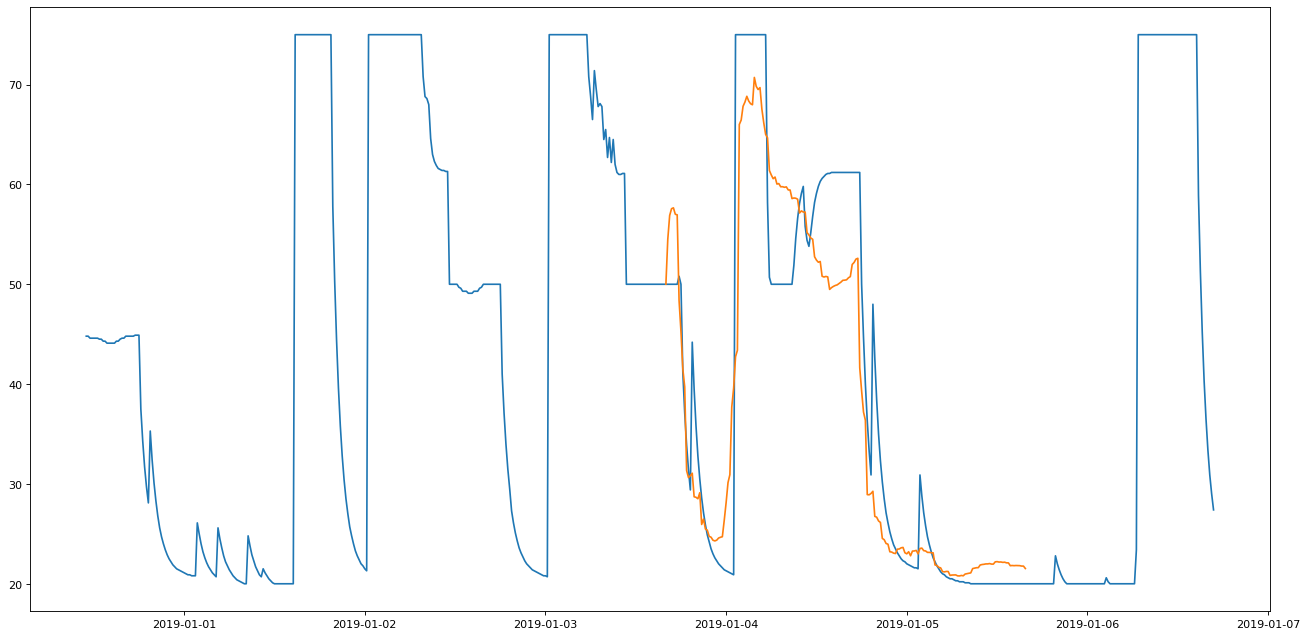

In [26]:
df_chunk = df_with_preds[78000:78600]
preds_last = df_chunk[["date / time", "predictions"]][-292:-291]
figure(figsize=(20, 10), dpi=80)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-292:-100],preds_last["predictions"].values[0] )

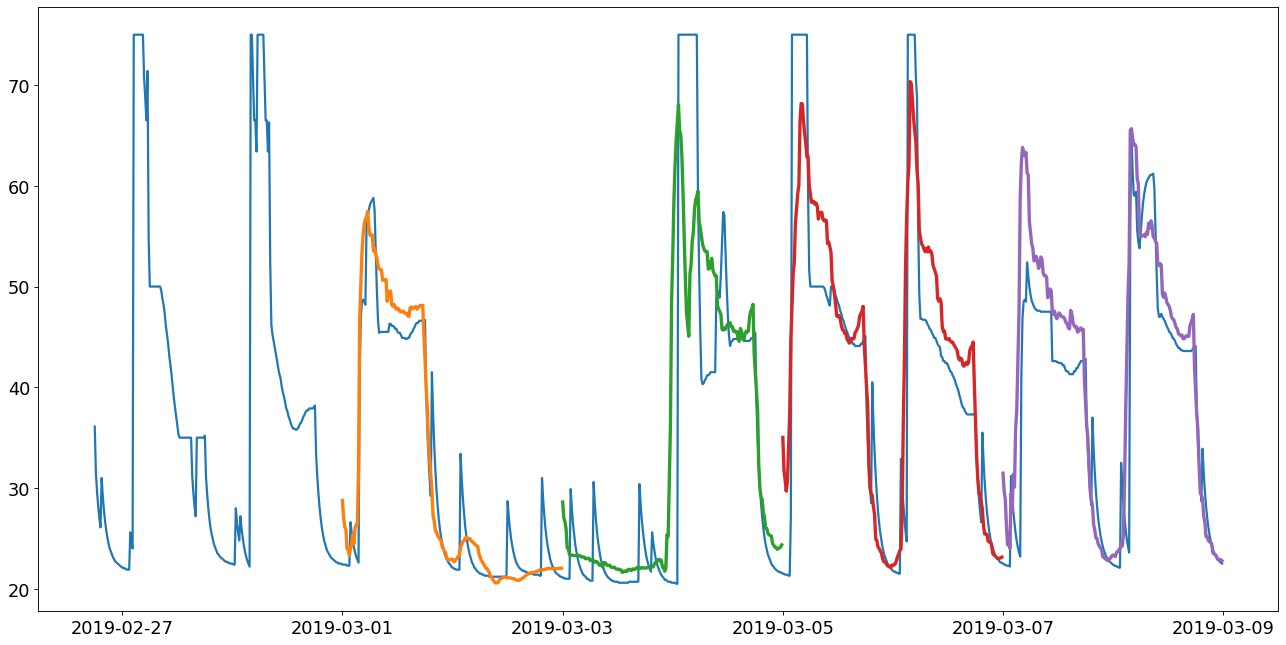

In [56]:

df_chunk = df_with_preds[83500:84484]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )


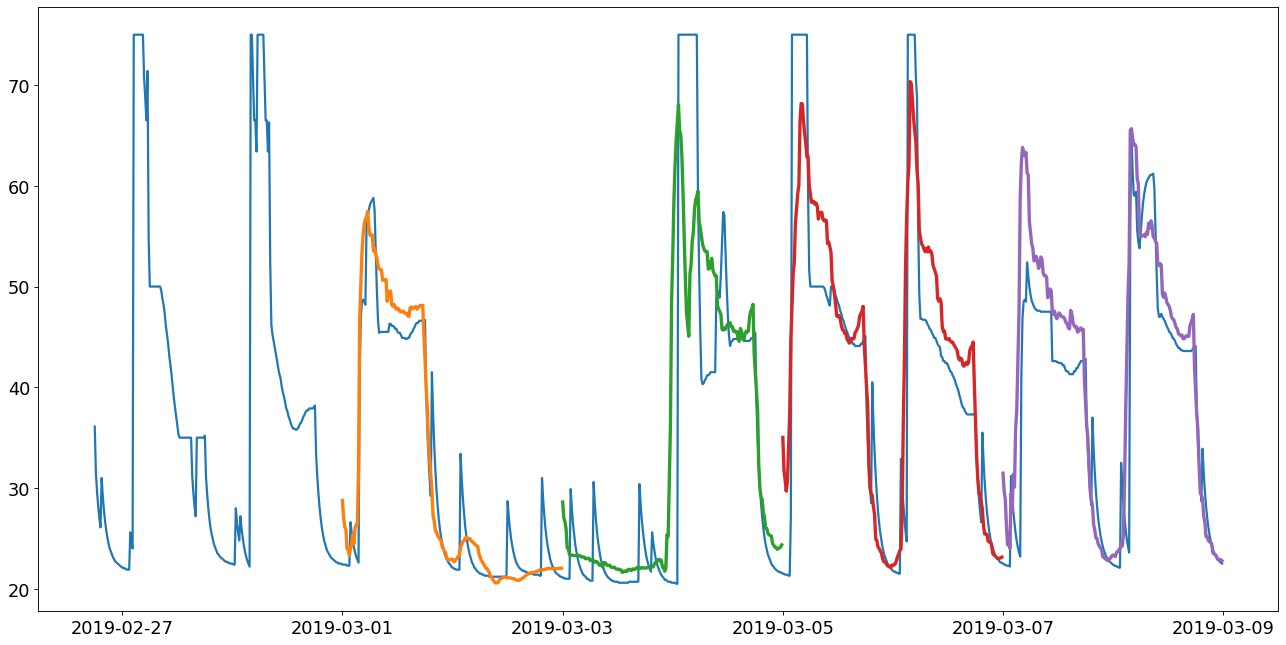

In [57]:
df_chunk = df_with_preds[83500:84484]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )


ValueError: x and y must have same first dimension, but have shapes (672,) and (192,)

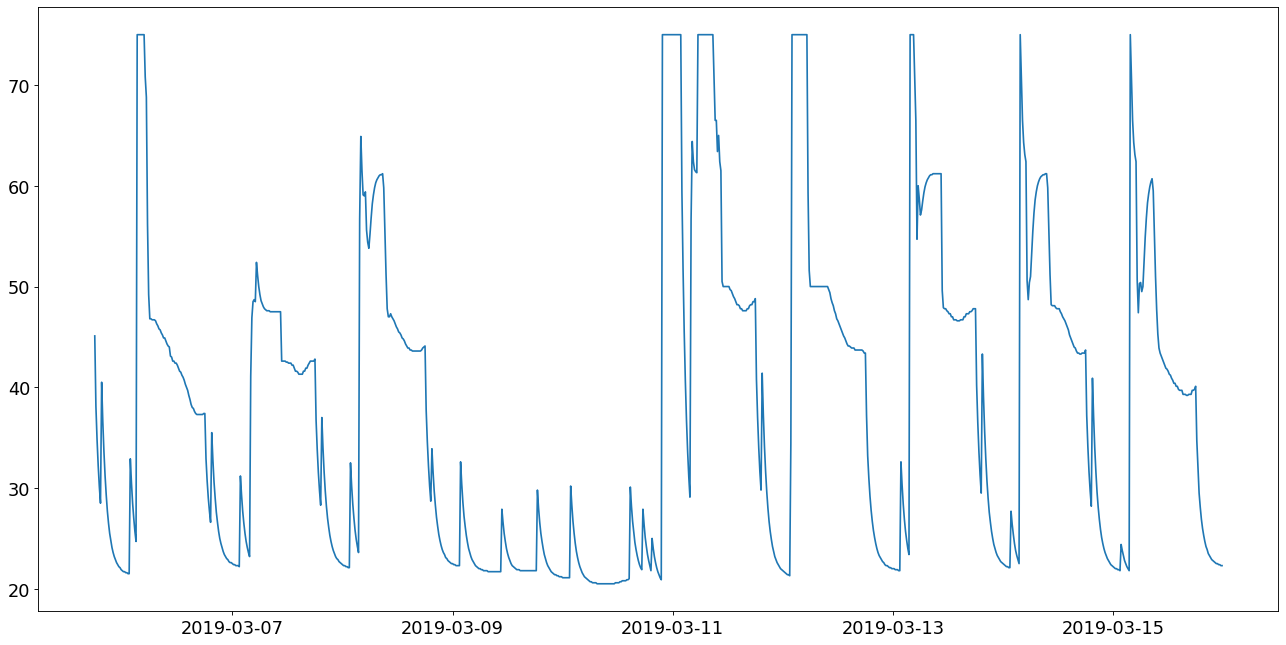

In [36]:
df_chunk = df_with_preds[84172:85156]

preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
#preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
#preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
#preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-96],preds_last_0["predictions"].values[0] )
#plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
#plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
#plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )


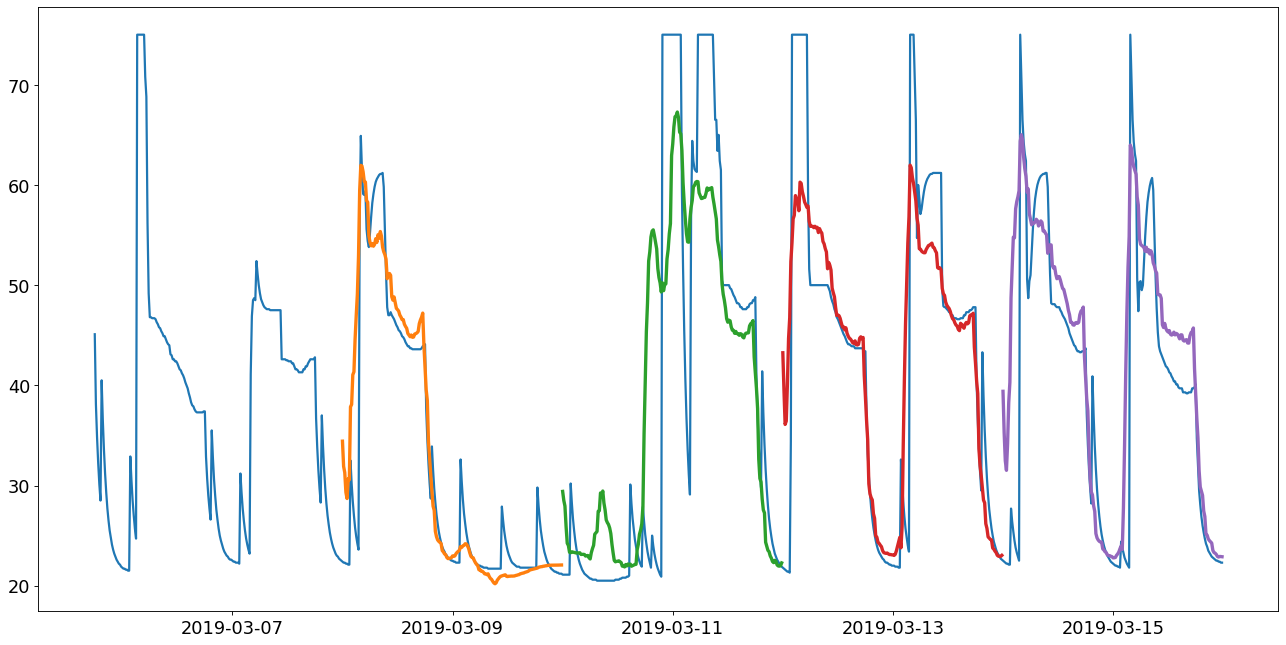

In [58]:
df_chunk = df_with_preds[84172:85156]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )

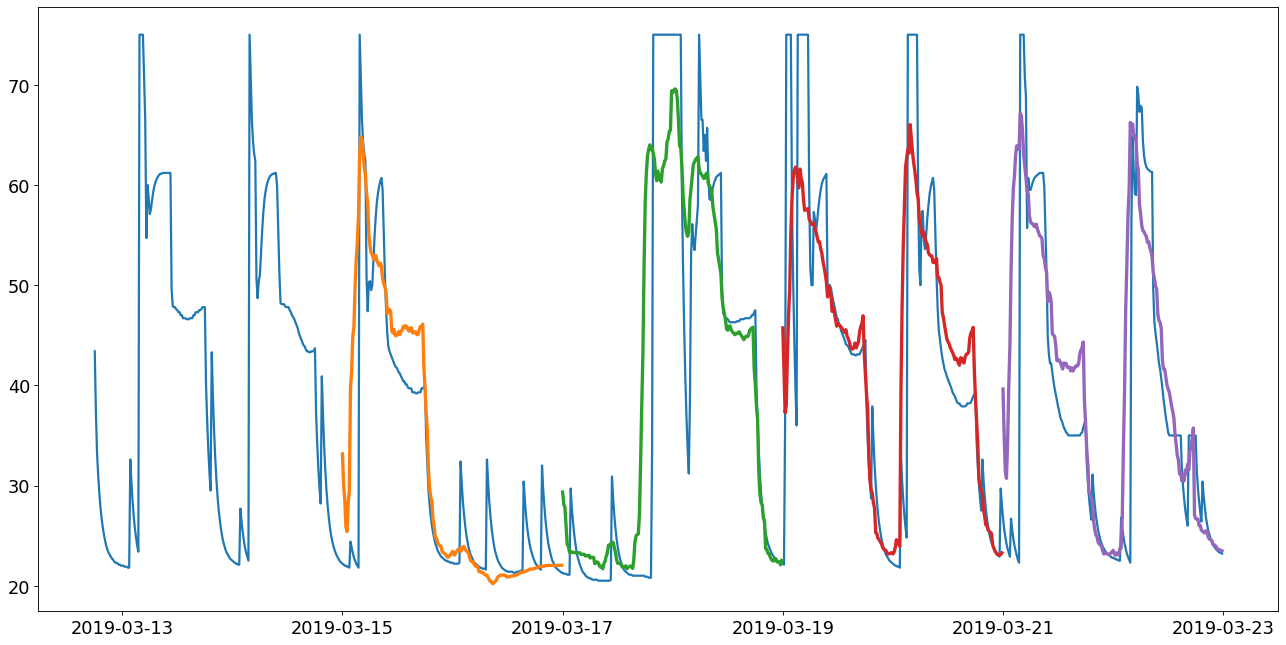

In [59]:
df_chunk = df_with_preds[84844:85828]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )

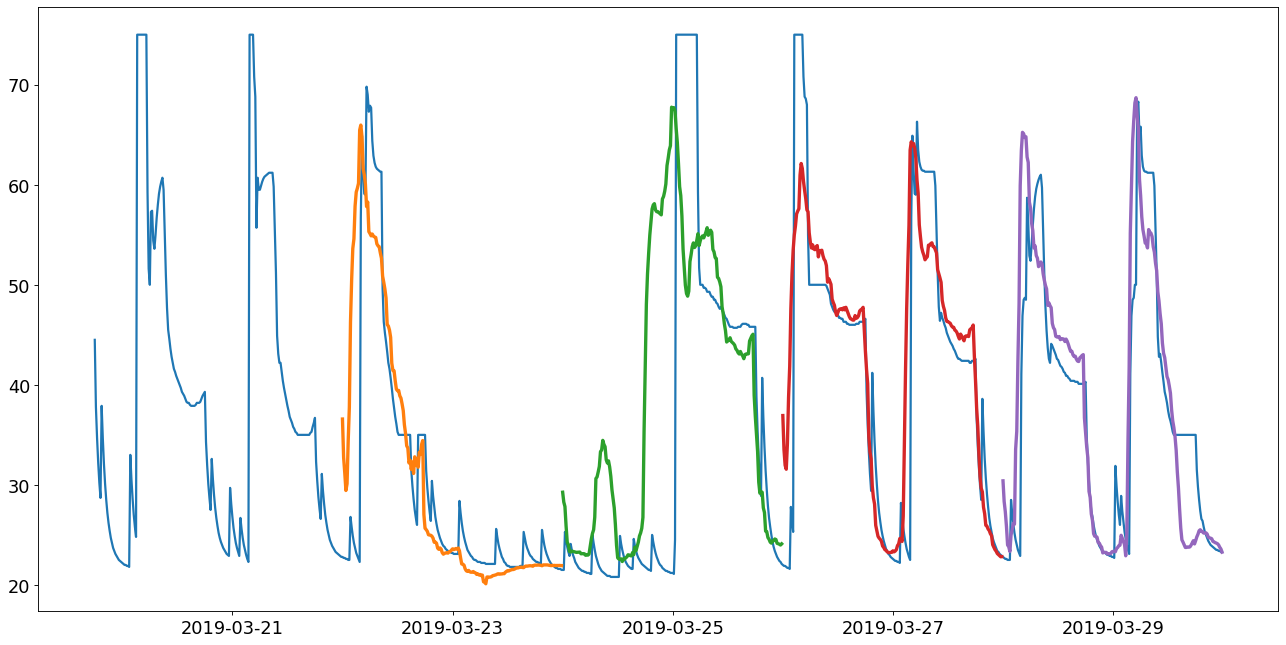

In [60]:
df_chunk = df_with_preds[85516:86500]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )

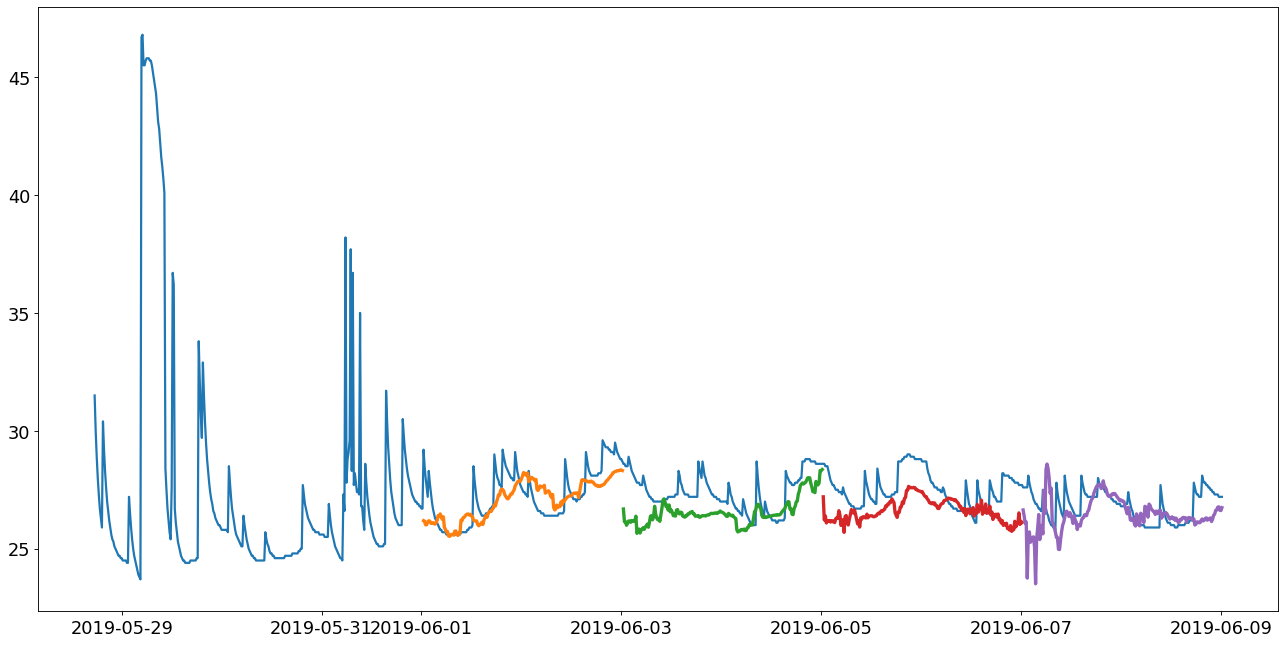

In [61]:
df_chunk = df_with_preds[92230:93314]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )

ValueError: x and y must have same first dimension, but have shapes (672,) and (192,)

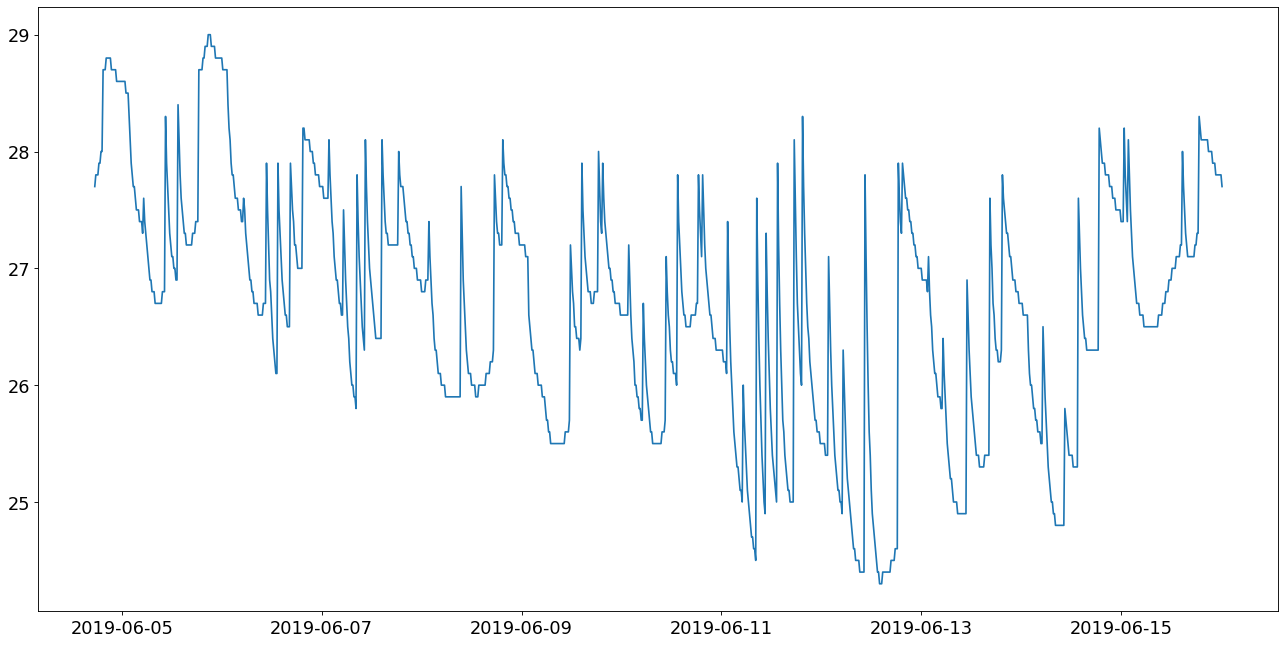

In [41]:
df_chunk = df_with_preds[92902:93986]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-96],preds_last_0["predictions"].values[0] )

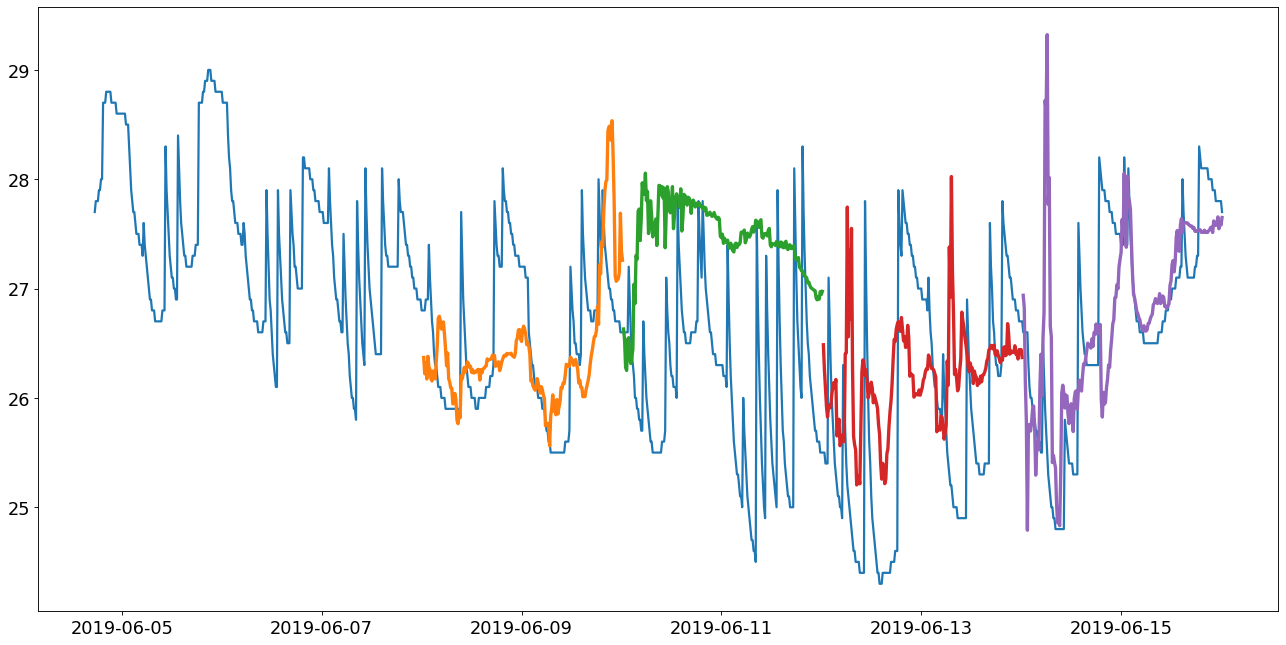

In [62]:
df_chunk = df_with_preds[92902:93986]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )

ValueError: x and y must have same first dimension, but have shapes (672,) and (192,)

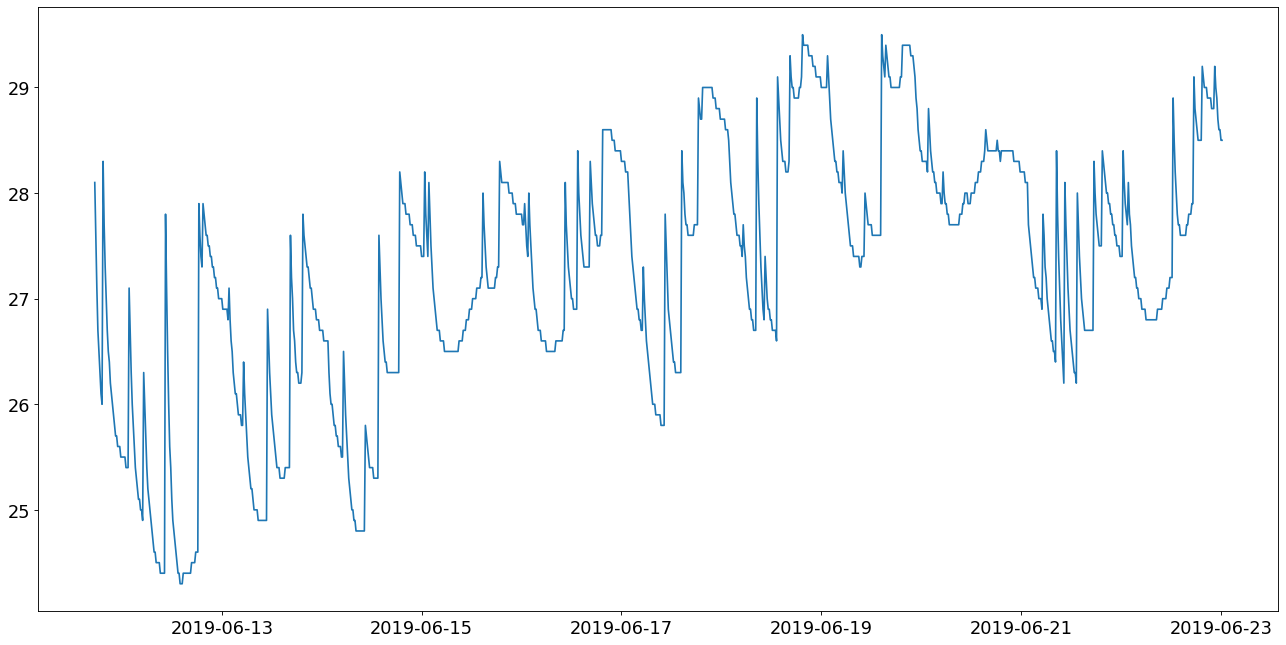

In [63]:
df_chunk = df_with_preds[93574:94658]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-96],preds_last_0["predictions"].values[0] )

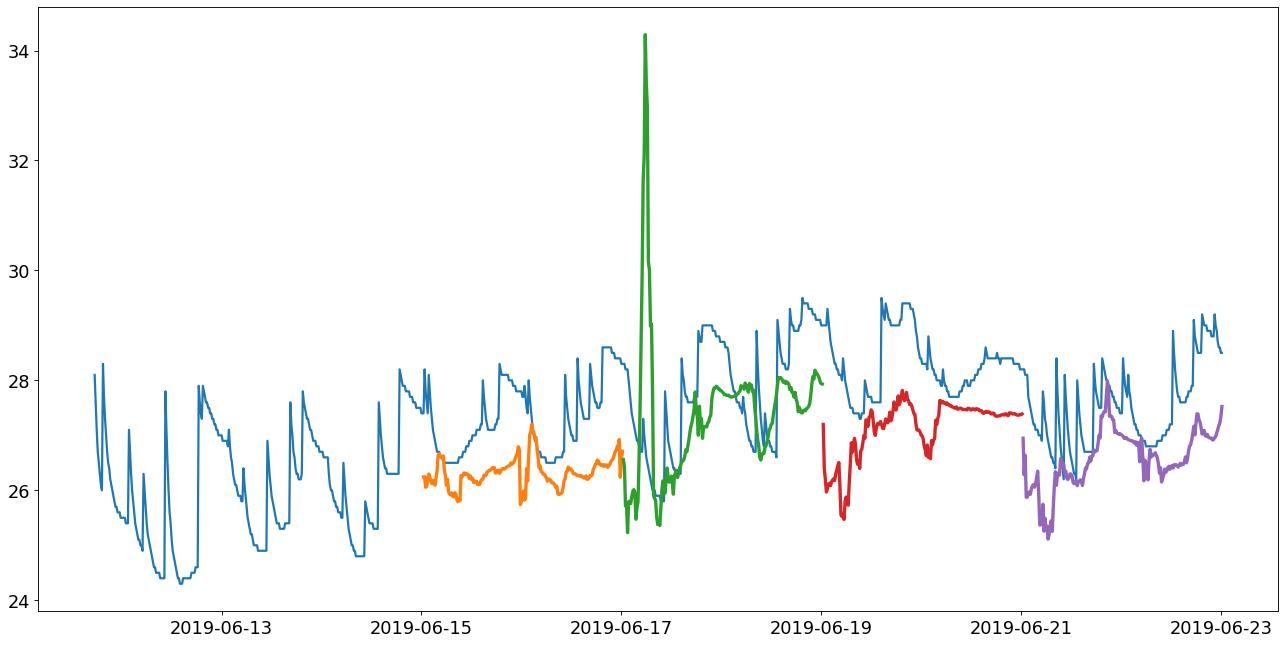

In [64]:
df_chunk = df_with_preds[93574:94658]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )

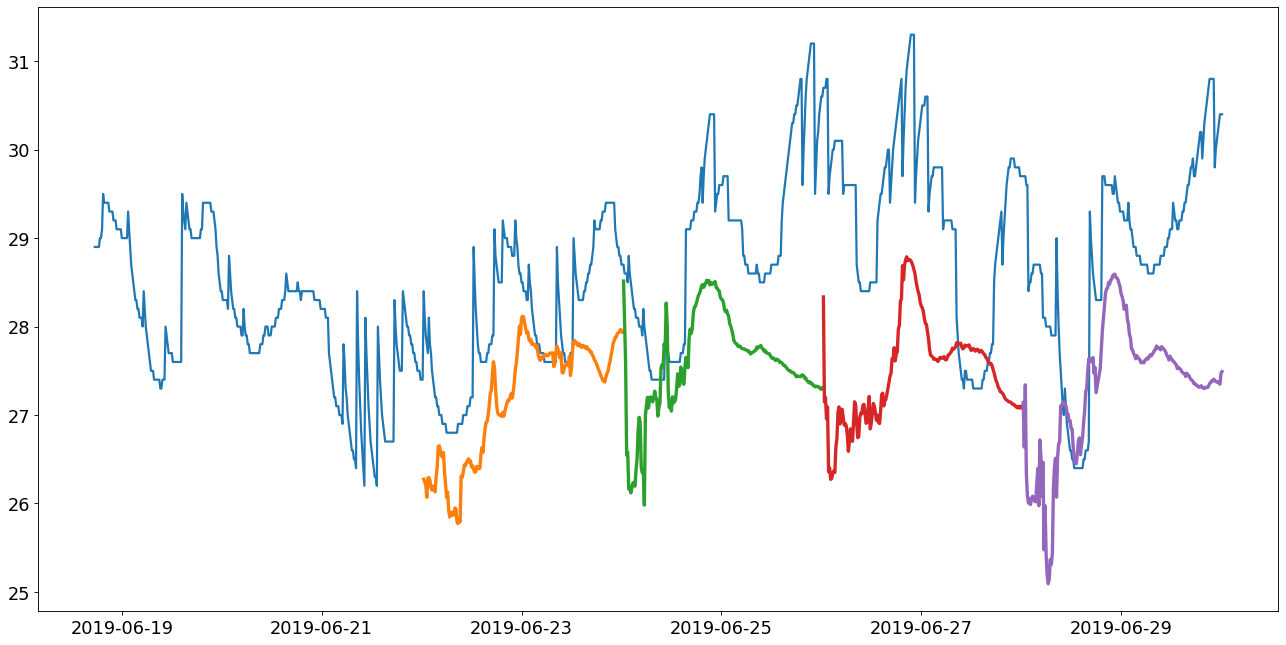

In [65]:
df_chunk = df_with_preds[94246:95330]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"], linewidth=2)
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0], linewidth=3 )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0], linewidth=3 )

In [15]:
# save model
save_path = config_path
model.save_model(save_path)

In [43]:
# create dataset and model from saved configs
dataset_loaded = DataSet()
dataset_loaded.load_data(data_path, file_type="xlsx")

In [44]:
dataset_loaded.process_from_config\
    (config_path=config_path, split_ratio=0.7)

In [45]:
model = TCN_Seq2Seq()
X_call = []
for el in dataset_loaded.X:
    X_call.append(el[:2])
model.load_model(config_path,
                        X_call)

In [46]:
# check if it worked
X_train, y_train, X_val, y_val = dataset_loaded.train_test_split(split_ratio)

In [47]:
# evaluate train and val set without scaling
#score_train = model.eval(X_train, y_train, iterations=1)
#print(f"score train: {score_train}")
score_val = model.eval(X_val, y_val, iterations=1)
print(f"score val: {score_val}")

score val: 0.2429496551751181


In [ ]:
dataset.df_processed

In [ ]:
df_without_last_year = dataset.df_processed[dataset.df_processed["date / time"].year() < 2019]

In [ ]:
df_processed['date / time'] = pd.to_datetime(df_processed['date / time'])  

In [ ]:
df_without_last_year = df_processed[df_processed["date / time"] < '2019-1-1']

In [ ]:
df_without_last_year

In [ ]:
df_last_year = df_processed[df_processed["date / time"] >= '2019-1-1']

In [ ]:
df_last_year